In [509]:
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

# imports

In [34]:
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime

# paths

In [55]:
data_path = os.path.join("..", "data")
diet_path = os.path.join(data_path, "diet", "history_19ced360-151c-430a-a084-986a5f36c3a1.csv")
weight_path = os.path.join(data_path, "weight", "mm_weighttracker_backup_2022_03_06.csv")
workout_path = os.path.join(data_path, "workout")
output_path = os.path.join(data_path, "output")

open_scale_path = os.path.join(data_path, "OpenScale", "openScale.db")
waistline_path = os.path.join(data_path, "WaistLine", "waistline_auto_backup.json")

# data

### diet

In [56]:
# load
diet_df = pd.read_csv(diet_path, delimiter=";")
# rename
diet_df = diet_df.rename(columns={"Unnamed: 0": "date", "Calories (kcal)": "calories", "Fat (g)": "fats", "Carbohydrate (g)": "carbs", "Protein (g)": "proteins"})
# index
diet_df = diet_df.set_index(pd.to_datetime(diet_df["date"], infer_datetime_format=True))
diet_df = diet_df.reindex(index=diet_df.index[::-1])
# select
diet_df = diet_df[["calories", "fats", "carbs", "proteins"]]
# add columns
diet_df["macros"] = diet_df.fats*9 + diet_df.carbs*4 + diet_df.proteins*4
diet_df["fats_pct"] = diet_df.fats*9/diet_df.macros
diet_df["carbs_pct"] = diet_df.carbs*4/diet_df.macros
diet_df["proteins_pct"] = diet_df.proteins*4/diet_df.macros
# drop below 1000 kcal
diet_df = diet_df[~(diet_df.calories <= 1000)]

print(diet_df.head())

            calories  fats  carbs  proteins  macros  fats_pct  carbs_pct  \
date                                                                       
2020-08-20      1453   117     18        82    1453  0.724708   0.049553   
2020-08-21      1596   116     17       121    1596  0.654135   0.042607   
2020-08-22      1692   131     16       113    1695  0.695575   0.037758   
2020-08-23      1638   131     26        89    1639  0.719341   0.063453   
2020-08-24      1585   112     24       121    1588  0.634761   0.060453   

            proteins_pct  
date                      
2020-08-20      0.225740  
2020-08-21      0.303258  
2020-08-22      0.266667  
2020-08-23      0.217206  
2020-08-24      0.304786  


### weight

In [57]:
# load
weight_df = pd.read_csv(weight_path, delimiter=",")
# rename
weight_df = weight_df.rename(columns={"Date (YYYY-MM-DD)": "date", "Weight (kg)": "weight"})
# index
weight_df.date = weight_df.date.apply(lambda s: s[2:-1])
weight_df = weight_df.set_index(pd.to_datetime(weight_df["date"], infer_datetime_format=True))
weight_df = weight_df.groupby(weight_df.index).mean()
# select
weight_df = weight_df[["weight"]]

print(weight_df.head())

            weight
date              
2020-08-01    80.0
2020-08-23    75.0
2020-09-01    73.7
2020-09-04    73.9
2020-09-06    73.3


### OpenScale

In [58]:
# load data
db = sqlite3.connect(open_scale_path)
open_scale = pd.read_sql_query("SELECT * from scaleMeasurements", db)
users = pd.read_sql_query("SELECT * from scaleUsers", db)
db.close()

# remove disabled
open_scale = open_scale[open_scale.enabled == 1]

# select columns
open_scale = open_scale[["userId", "datetime", "weight"]]
users = users[["id", "username", "bodyHeight"]]

# join tables
open_scale = open_scale.set_index("userId").join(users.set_index("id"))

# set datetime index
open_scale.datetime = pd.to_datetime(open_scale.datetime.apply(lambda x: datetime.fromtimestamp(x/1e3)))
open_scale = open_scale.set_index(["datetime"])

# calculate bmi
open_scale["bmi"] = open_scale.apply(lambda x: x.weight/(x.bodyHeight/100)**2, axis=1)

print(open_scale.head())

                        weight      username  bodyHeight        bmi
datetime                                                           
2022-03-06 12:15:00  66.949997  Heiko Raible       176.0  21.613506
2022-03-07 14:20:00  67.199997  Heiko Raible       176.0  21.694214
2022-03-08 10:48:00  67.400002  Heiko Raible       176.0  21.758781
2022-03-09 14:02:00  67.500000  Heiko Raible       176.0  21.791064
2022-03-10 14:39:00  67.500000  Heiko Raible       176.0  21.791064


### merge

In [59]:
# user heiko
open_scale_heiko = open_scale[open_scale.username == "Heiko Raible"]
# merge weights
merged_weight_df = pd.concat([weight_df, open_scale_heiko], axis=0)
merged_weight_df.drop(["username", "bodyHeight", "bmi"], axis=1, inplace=True)
# merge data
data = pd.merge(diet_df, merged_weight_df, how="outer", left_index=True, right_index=True)

print(data.head())

            calories   fats  carbs  proteins  macros  fats_pct  carbs_pct  \
2020-08-01       NaN    NaN    NaN       NaN     NaN       NaN        NaN   
2020-08-20    1453.0  117.0   18.0      82.0  1453.0  0.724708   0.049553   
2020-08-21    1596.0  116.0   17.0     121.0  1596.0  0.654135   0.042607   
2020-08-22    1692.0  131.0   16.0     113.0  1695.0  0.695575   0.037758   
2020-08-23    1638.0  131.0   26.0      89.0  1639.0  0.719341   0.063453   

            proteins_pct  weight  
2020-08-01           NaN    80.0  
2020-08-20      0.225740     NaN  
2020-08-21      0.303258     NaN  
2020-08-22      0.266667     NaN  
2020-08-23      0.217206    75.0  


### trim data before 25.07.2021

In [60]:
data_after = data.loc["2021-07-25":]

print(data_after.head())

            calories  fats  carbs  proteins  macros  fats_pct  carbs_pct  \
2021-07-25    1298.0  63.0   47.0     123.0  1247.0  0.454691   0.150762   
2021-07-26    1108.0  27.0  144.0      63.0  1071.0  0.226891   0.537815   
2021-07-27    1487.0  47.0  113.0     144.0  1451.0  0.291523   0.311509   
2021-07-28    1486.0  50.0  120.0     134.0  1466.0  0.306958   0.327422   
2021-07-29    1105.0  28.0   59.0     143.0  1060.0  0.237736   0.222642   

            proteins_pct  weight  
2021-07-25      0.394547   73.40  
2021-07-26      0.235294     NaN  
2021-07-27      0.396968   73.10  
2021-07-28      0.365621   72.70  
2021-07-29      0.539623   72.45  


# plots

### weight vs. calories

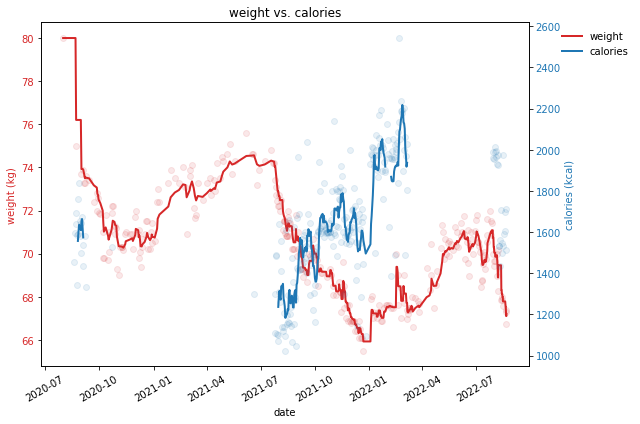

In [61]:
fig, ax1 = plt.subplots(figsize=(9, 6))

# colors
color = "tab:red"
color2 = "tab:blue"

# ax1
weight = ax1.plot(data.index, data.weight.ewm(span=7).mean(), linestyle="solid", linewidth=2, color=color, label="weight")
ax1.scatter(data.index, data.weight, color=color, alpha=0.1)
ax1.set_ylabel("weight (kg)")
ax1.tick_params(axis="y", labelcolor=color)
ax1.yaxis.label.set_color(color)

# ax2
ax2 = ax1.twinx()
calories = ax2.plot(data.index, data.calories.rolling(7).mean(), linestyle="solid", linewidth=2, color=color2, label="calories")
ax2.scatter(data.index, data.calories, color=color2, alpha=0.1)
ax2.set_ylabel("calories (kcal)")
ax2.tick_params(axis="y", labelcolor=color2)
ax2.yaxis.label.set_color(color2)

# x axis
ax1.set_xlabel("date")
ax1.tick_params(axis="x", rotation=30)

# settings
plt.title("weight vs. calories")
legends = weight+calories
labels = [legend.get_label() for legend in legends]
ax1.legend(legends, labels, bbox_to_anchor=(1.05, 1.0), loc="upper left", frameon=False)
fig.tight_layout()

plt.show()
fig.savefig(os.path.join(output_path, "weight_vs_calories.png"), bbox_inches="tight", facecolor="white")

### weight vs. macros

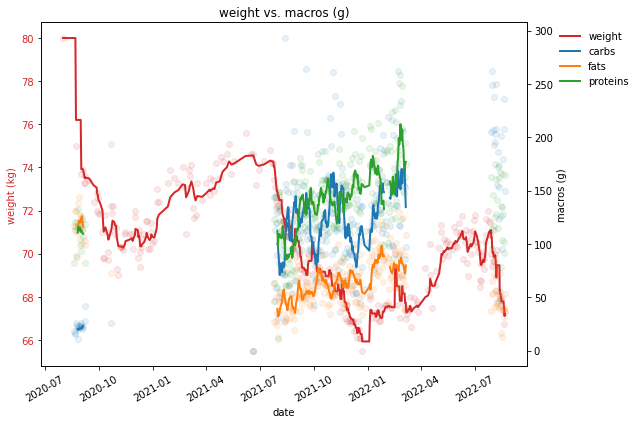

In [62]:
fig, ax1 = plt.subplots(figsize=(9, 6))

# colors
color = "tab:red"
carbs_color = "tab:blue"
fats_color = "tab:orange"
proteins_color = "tab:green"

# ax1
weight = ax1.plot(data.index, data.weight.ewm(span=7).mean(), linestyle="-", linewidth=2, color=color, label="weight")
ax1.scatter(data.index, data.weight, color=color, alpha=0.1)
ax1.set_ylabel("weight (kg)")
ax1.tick_params(axis="y", labelcolor=color)
ax1.yaxis.label.set_color(color)

# ax2
ax2 = ax1.twinx()
carbs = ax2.plot(data.index, data.carbs.rolling(7).mean(), linestyle="-", linewidth=2, color=carbs_color, label="carbs")
ax2.scatter(data.index, data.carbs, color=carbs_color, alpha=0.1)
fats = ax2.plot(data.index, data.fats.rolling(7).mean(), linestyle="-", linewidth=2, color=fats_color, label="fats")
ax2.scatter(data.index, data.fats, color=fats_color, alpha=0.1)
proteins = ax2.plot(data.index, data.proteins.rolling(7).mean(), linestyle="-", linewidth=2, color=proteins_color, label="proteins")
ax2.scatter(data.index, data.proteins, color=proteins_color, alpha=0.1)
ax2.set_ylabel("macros (g)")

# x axis
ax1.set_xlabel("date")
ax1.tick_params(axis="x", rotation=30)

# settings
plt.title("weight vs. macros (g)")
legends = weight+carbs+fats+proteins
labels = [legend.get_label() for legend in legends]
ax1.legend(legends, labels, bbox_to_anchor=(1.05, 1.0), loc="upper left", frameon=False)
fig.tight_layout()

plt.show()
fig.savefig(os.path.join(output_path, "weight_vs_macros_g.png"), bbox_inches="tight", facecolor="white")

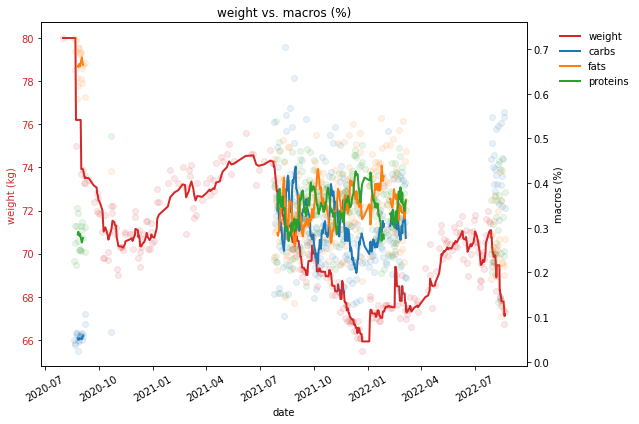

In [63]:
fig, ax1 = plt.subplots(figsize=(9, 6))

# colors
color = "tab:red"
carbs_color = "tab:blue"
fats_color = "tab:orange"
proteins_color = "tab:green"

# ax1
weight = ax1.plot(data.index, data.weight.ewm(span=7).mean(), linestyle="-", linewidth=2, color=color, label="weight")
ax1.scatter(data.index, data.weight, color=color, alpha=0.1)
ax1.set_ylabel("weight (kg)")
ax1.tick_params(axis="y", labelcolor=color)
ax1.yaxis.label.set_color(color)

# ax2
ax2 = ax1.twinx()
carbs = ax2.plot(data.index, data.carbs_pct.rolling(7).mean(), linestyle="-", linewidth=2, color=carbs_color, label="carbs")
ax2.scatter(data.index, data.carbs_pct, color=carbs_color, alpha=0.1)
fats = ax2.plot(data.index, data.fats_pct.rolling(7).mean(), linestyle="-", linewidth=2, color=fats_color, label="fats")
ax2.scatter(data.index, data.fats_pct, color=fats_color, alpha=0.1)
proteins = ax2.plot(data.index, data.proteins_pct.rolling(7).mean(), linestyle="-", linewidth=2, color=proteins_color, label="proteins")
ax2.scatter(data.index, data.proteins_pct, color=proteins_color, alpha=0.1)
ax2.set_ylabel("macros (%)")

# x axis
ax1.set_xlabel("date")
ax1.tick_params(axis="x", rotation=30)

# settings
plt.title("weight vs. macros (%)")
legends = weight+carbs+fats+proteins
labels = [legend.get_label() for legend in legends]
ax1.legend(legends, labels, bbox_to_anchor=(1.05, 1.0), loc="upper left", frameon=False)
fig.tight_layout()

plt.show()
fig.savefig(os.path.join(output_path, "weight_vs_macros_pct.png"), bbox_inches="tight", facecolor="white")

### only for dates after 25.07.2021

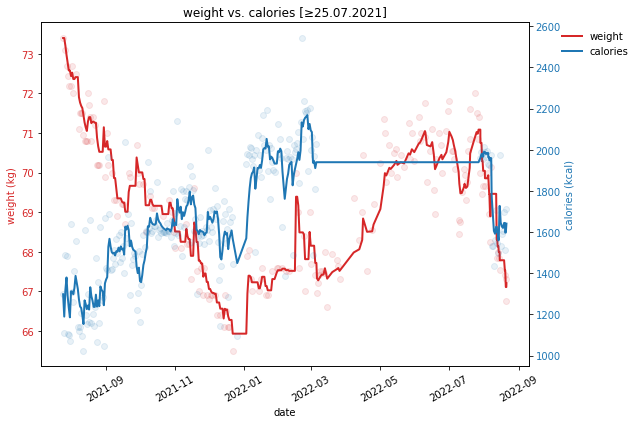

In [74]:
fig, ax1 = plt.subplots(figsize=(9, 6))

# colors
color = "tab:red"
color2 = "tab:blue"

# ax1
weight = ax1.plot(data_after.index, data_after.weight.ewm(span=7).mean(), linestyle="solid", linewidth=2, color=color, label="weight")
ax1.scatter(data_after.index, data_after.weight, color=color, alpha=0.1)
ax1.set_ylabel("weight (kg)")
ax1.tick_params(axis="y", labelcolor=color)
ax1.yaxis.label.set_color(color)

# ax2
ax2 = ax1.twinx()
calories = ax2.plot(data_after.index, data_after.calories.ewm(span=7).mean(), linestyle="solid", linewidth=2, color=color2, label="calories")
ax2.scatter(data_after.index, data_after.calories, color=color2, alpha=0.1)
ax2.set_ylabel("calories (kcal)")
ax2.tick_params(axis="y", labelcolor=color2)
ax2.yaxis.label.set_color(color2)

# x axis
ax1.set_xlabel("date")
ax1.tick_params(axis="x", rotation=30)

# settings
plt.title("weight vs. calories [≥25.07.2021]")
legends = weight+calories
labels = [legend.get_label() for legend in legends]
ax1.legend(legends, labels, bbox_to_anchor=(1.05, 1.0), loc="upper left", frameon=False)
fig.tight_layout()

plt.show()
fig.savefig(os.path.join(output_path, "weight_vs_calories_after_25_07_2021.png"), bbox_inches="tight", facecolor="white")

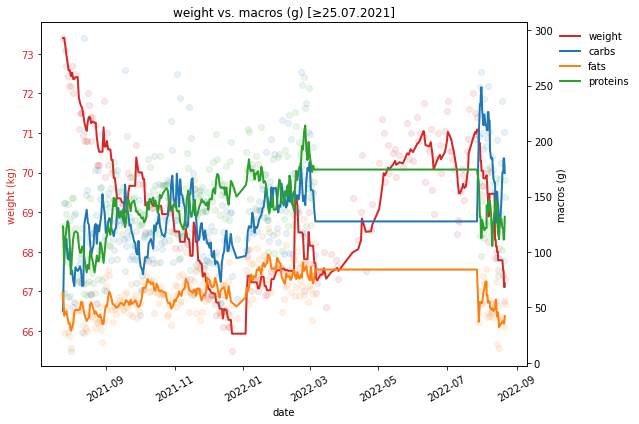

In [73]:
fig, ax1 = plt.subplots(figsize=(9, 6))

# colors
color = "tab:red"
carbs_color = "tab:blue"
fats_color = "tab:orange"
proteins_color = "tab:green"

# ax1
weight = ax1.plot(data_after.index, data_after.weight.ewm(span=7).mean(), linestyle="-", linewidth=2, color=color, label="weight")
ax1.scatter(data_after.index, data_after.weight, color=color, alpha=0.1)
ax1.set_ylabel("weight (kg)")
ax1.tick_params(axis="y", labelcolor=color)
ax1.yaxis.label.set_color(color)

# ax2
ax2 = ax1.twinx()
carbs = ax2.plot(data_after.index, data_after.carbs.ewm(span=7).mean(), linestyle="-", linewidth=2, color=carbs_color, label="carbs")
ax2.scatter(data_after.index, data_after.carbs, color=carbs_color, alpha=0.1)
fats = ax2.plot(data_after.index, data_after.fats.ewm(span=7).mean(), linestyle="-", linewidth=2, color=fats_color, label="fats")
ax2.scatter(data_after.index, data_after.fats, color=fats_color, alpha=0.1)
proteins = ax2.plot(data_after.index, data_after.proteins.ewm(span=7).mean(), linestyle="-", linewidth=2, color=proteins_color, label="proteins")
ax2.scatter(data_after.index, data_after.proteins, color=proteins_color, alpha=0.1)
ax2.set_ylabel("macros (g)")

# x axis
ax1.set_xlabel("date")
ax1.tick_params(axis="x", rotation=30)

# settings
plt.title("weight vs. macros (g) [≥25.07.2021]")
legends = weight+carbs+fats+proteins
labels = [legend.get_label() for legend in legends]
ax1.legend(legends, labels, bbox_to_anchor=(1.05, 1.0), loc="upper left", frameon=False)
fig.tight_layout()

plt.show()
fig.savefig(os.path.join(output_path, "weight_vs_macros_g_after_25_07_2021.png"), bbox_inches="tight", facecolor="white")

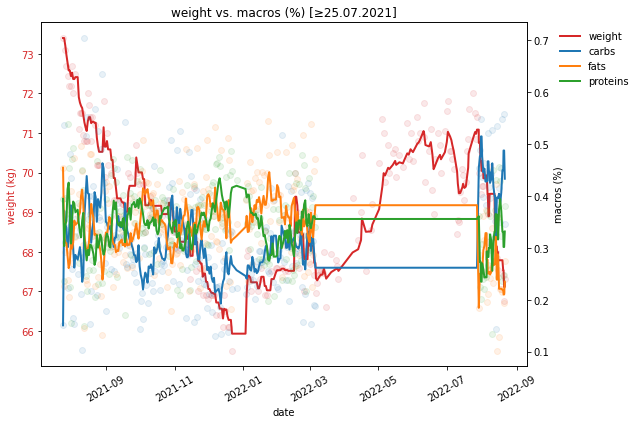

In [72]:
fig, ax1 = plt.subplots(figsize=(9, 6))

# colors
color = "tab:red"
carbs_color = "tab:blue"
fats_color = "tab:orange"
proteins_color = "tab:green"

# ax1
weight = ax1.plot(data_after.index, data_after.weight.ewm(span=7).mean(), linestyle="-", linewidth=2, color=color, label="weight")
ax1.scatter(data_after.index, data_after.weight, color=color, alpha=0.1)
ax1.set_ylabel("weight (kg)")
ax1.tick_params(axis="y", labelcolor=color)
ax1.yaxis.label.set_color(color)

# ax2
ax2 = ax1.twinx()
carbs = ax2.plot(data_after.index, data_after.carbs_pct.ewm(span=7).mean(), linestyle="-", linewidth=2, color=carbs_color, label="carbs")
ax2.scatter(data_after.index, data_after.carbs_pct, color=carbs_color, alpha=0.1)
fats = ax2.plot(data_after.index, data_after.fats_pct.ewm(span=7).mean(), linestyle="-", linewidth=2, color=fats_color, label="fats")
ax2.scatter(data_after.index, data_after.fats_pct, color=fats_color, alpha=0.1)
proteins = ax2.plot(data_after.index, data_after.proteins_pct.ewm(span=7).mean(), linestyle="-", linewidth=2, color=proteins_color, label="proteins")
ax2.scatter(data_after.index, data_after.proteins_pct, color=proteins_color, alpha=0.1)
ax2.set_ylabel("macros (%)")

# x axis
ax1.set_xlabel("date")
ax1.tick_params(axis="x", rotation=30)

# settings
plt.title("weight vs. macros (%) [≥25.07.2021]")
legends = weight+carbs+fats+proteins
labels = [legend.get_label() for legend in legends]
ax1.legend(legends, labels, bbox_to_anchor=(1.05, 1.0), loc="upper left", frameon=False)
fig.tight_layout()

plt.show()
fig.savefig(os.path.join(output_path, "weight_vs_macros_pct_after_25_07_2021.png"), bbox_inches="tight", facecolor="white")

In [524]:
HTML('''
<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Created using Jupyter.
</footer>
''')